#### We would run a set of models to establish a base line of accuracy

In [1]:
import pandas as panda
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler,RobustScaler,label_binarize

from sklearn.model_selection import train_test_split,KFold,StratifiedKFold,GridSearchCV,\
    RepeatedStratifiedKFold,learning_curve

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.manifold import TSNE
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, auc, precision_recall_curve, \
        classification_report,confusion_matrix,average_precision_score
from sklearn.linear_model import Perceptron, LogisticRegression,RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from matplotlib import pyplot as plot
from itertools import cycle
import numpy as np 
from scipy import interp
import seaborn as sns
import itertools, time, datetime
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from numpy import bincount, linspace, mean, std, arange, squeeze

import warnings

warnings.simplefilter('ignore')
%matplotlib inline

In [2]:
np.random.seed(123)

In [3]:
class CodeTimer:
    
    """
        Utility custom contextual class for calculating the time 
        taken for a certain code block to execute
    
    """
    def __init__(self, name=None):
        self.name = " '"  + name + "'" if name else ''

    def __enter__(self):
        self.start = time.clock()

    def __exit__(self, exc_type, exc_value, traceback):
        self.took = (time.clock() - self.start) * 1000.0
        time_taken = datetime.timedelta(milliseconds = self.took)
        print('Code block' + self.name + ' took(HH:MM:SS): ' + str(time_taken))

In [4]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plot.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plot.imshow(cm, interpolation='nearest', cmap=cmap)
    plot.title(title)
    plot.colorbar()
    tick_marks = arange(len(classes))
    plot.xticks(tick_marks, classes, rotation=45)
    plot.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plot.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plot.ylabel('True label')
    plot.xlabel('Predicted label')
#     plot.tight_layout()
    plot.show()

In [5]:
## over sampling majorities first 

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks

from imblearn.combine import SMOTETomek

smt = SMOTETomek(ratio='auto')
# _x_train, _y_train = smt.fit_sample(_x_train, _y_train)

# smote = SMOTE(ratio='minority')
# x_train, y_train = smote.fit_sample(_x_train,_y_train)

# tl = TomekLinks(return_indices=True, ratio='majority')
# _x_train, _y_train, id_tl = tl.fit_sample(_x_train, _y_train)



In [6]:
class CodeTimer:
    
    """
        Utility custom contextual class for calculating the time 
        taken for a certain code block to execute
    
    """
    def __init__(self, name=None):
        self.name = " '"  + name + "'" if name else ''

    def __enter__(self):
        self.start = time.clock()

    def __exit__(self, exc_type, exc_value, traceback):
        self.took = (time.clock() - self.start) * 1000.0
        time_taken = datetime.timedelta(milliseconds = self.took)
        print('Code block' + self.name + ' took(HH:MM:SS): ' + str(time_taken))





def calculate_roc_and_prec_metrics(y, y_probabilities, number_of_classes):
    
    false_positive_rate_across_class    = dict()
    true_positive_rate_across_class     = dict()
    recall_across_class                 = dict()
    precision_across_class              = dict()
    roc_auc_across_class                = dict()
    average_precision_across_class      = dict()


    for i in range(number_of_classes):

        false_positive_rate_across_class[i], \
                true_positive_rate_across_class[i], _ = roc_curve(y[:, i], y_probabilities[:, i])

        precision_across_class[i], recall_across_class[i], _ = precision_recall_curve(y[:, i],
                                                        y_probabilities[:, i])

        average_precision_across_class[i] = average_precision_score(y[:, i], y_probabilities[:, i])

        roc_auc_across_class[i] = auc(false_positive_rate_across_class[i], true_positive_rate_across_class[i])

        # Compute micro-average ROC curve and ROC area

        false_positive_rate_across_class["micro"], \
                true_positive_rate_across_class["micro"], _ = roc_curve(y.ravel(), y_probabilities.ravel())

        roc_auc_across_class["micro"] = auc(false_positive_rate_across_class["micro"], \
                            true_positive_rate_across_class["micro"])


        precision_across_class["micro"], recall_across_class["micro"], _ = \
                    precision_recall_curve(y.ravel(), y_probabilities.ravel())

        average_precision_across_class["micro"] = average_precision_score(y, y_probabilities,
                                                            average="micro")

    response  = dict() 
    response['false_positive_rate_across_class']    = false_positive_rate_across_class
    response['true_positive_rate_across_class']     = true_positive_rate_across_class
    response['recall_across_class']                 = recall_across_class
    response['precision_across_class']              = precision_across_class
    response['roc_auc_across_class']                = roc_auc_across_class
    response['average_precision_across_class']      = average_precision_across_class

    return response


def plot_roc_auc_curve(false_positive_rate_across_class, \
            true_positive_rate_across_class, roc_auc_across_class, n_classes):
    
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([false_positive_rate_across_class[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)

    for i in range(n_classes):
        mean_tpr += interp(all_fpr, false_positive_rate_across_class[i], true_positive_rate_across_class[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    false_positive_rate_across_class["macro"] = all_fpr
    true_positive_rate_across_class["macro"] = mean_tpr
    roc_auc_across_class["macro"] = auc(false_positive_rate_across_class["macro"], true_positive_rate_across_class["macro"])

    # Plot all ROC curves
    plot.figure(figsize = (15,5))
    plot.plot(false_positive_rate_across_class["micro"], true_positive_rate_across_class["micro"],
            label='micro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc_across_class["micro"]),
            color='deeppink', linestyle=':', linewidth=4)

    plot.plot(false_positive_rate_across_class["macro"], true_positive_rate_across_class["macro"],
            label='macro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc_across_class["macro"]),
            color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plot.plot(false_positive_rate_across_class[i], true_positive_rate_across_class[i], color=color, lw=4,
                label='ROC curve of class {0} (area = {1:0.2f})'
                ''.format(i, roc_auc_across_class[i]))

    plot.plot([0, 1], [0, 1], 'k--', lw=4)
    plot.xlim([0.0, 1.0])
    plot.ylim([0.0, 1.05])
    plot.xlabel('False Positive Rate')
    plot.ylabel('True Positive Rate')
    plot.title('Some extension of Receiver operating characteristic to multi-class')
    plot.legend(loc="lower right")
    plot.show()




def plot_precision_recall_curve(recall_across_class, \
            precision_across_class, average_precision_across_class, n_classes):

    line_width = 4
    from itertools import cycle
    # setup plot details
    colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

    plot.figure(figsize=(15, 8))
    f_scores = np.linspace(0.2, 0.8, num=4)
    lines = []
    labels = []
    for f_score in f_scores:
        x = np.linspace(0.01, 1)
        y = f_score * x / (2 * x - f_score)
        l, = plot.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
        plot.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

    lines.append(l)
    labels.append('iso-f1 curves')
    l, = plot.plot(recall_across_class["micro"], precision_across_class["micro"], color='gold', lw=line_width)
    lines.append(l)
    labels.append('micro-average Precision-recall (area = {0:0.2f})'
                ''.format(average_precision_across_class["micro"]))

    for i, color in zip(range(n_classes), colors):
        l, = plot.plot(recall_across_class[i], precision_across_class[i], color=color, lw=line_width)
        lines.append(l)
        labels.append('Precision-recall for class {0} (area = {1:0.2f})'
                    ''.format(i, average_precision_across_class[i]))

    fig = plot.gcf()
    fig.subplots_adjust(bottom=0.25)
    plot.xlim([0.0, 1.0])
    plot.ylim([0.0, 1.05])
    plot.xlabel('Recall')
    plot.ylabel('Precision')
    plot.title('Extension of Precision-Recall curve to multi-class')
#     plot.legend(lines, labels, loc=(0, -.38), prop=dict(size=14))
    plot.legend(lines, labels, loc='best', prop=dict(size=14))
    plot.show()

    

def plotLearningCurve(_x_train, _y_train, learning_model_pipeline,  k_fold = 10, training_sample_sizes = linspace(0.1,1.0,10), jobsInParallel = 1):
    
    training_size, training_score, testing_score = learning_curve(estimator = learning_model_pipeline, \
                                                                X = _x_train, \
                                                                y = _y_train, \
                                                                train_sizes = training_sample_sizes, \
                                                                cv = k_fold, \
                                                                n_jobs = jobsInParallel) 


    training_mean = mean(training_score, axis = 1)
    training_std_deviation = std(training_score, axis = 1)
    testing_std_deviation = std(testing_score, axis = 1)
    testing_mean = mean(testing_score, axis = 1 )

    ## we have got the estimator in this case the perceptron running in 10 fold validation with 
    ## equal division of sizes betwwen .1 and 1. After execution, we get the number of training sizes used, 
    ## the training scores for those sizes and the test scores for those sizes. we will plot a scatter plot 
    ## to see the accuracy results and check for bias vs variance

    # training_size : essentially 10 sets of say a1, a2, a3,,...a10 sizes (this comes from train_size parameter, here we have given linespace for equal distribution betwwen 0.1 and 1 for 10 such values)
    # training_score : training score for the a1 samples, a2 samples...a10 samples, each samples run 10 times since cv value is 10
    # testing_score : testing score for the a1 samples, a2 samples...a10 samples, each samples run 10 times since cv value is 10
    ## the mean and std deviation for each are calculated simply to show ranges in the graph

    plot.plot(training_size, training_mean, label= "Training Data", marker= '+', color = 'blue', markersize = 8)
    plot.fill_between(training_size, training_mean+ training_std_deviation, training_mean-training_std_deviation, color='blue', alpha =0.12 )

    plot.plot(training_size, testing_mean, label= "Testing/Validation Data", marker= '*', color = 'green', markersize = 8)
    plot.fill_between(training_size, testing_mean+ training_std_deviation, testing_mean-training_std_deviation, color='green', alpha =0.14 )

    plot.title("Scoring of our training and testing data vs sample sizes")
    plot.xlabel("Number of Samples")
    plot.ylabel("Accuracy")
    plot.legend(loc= 'best')
    plot.show()
    
    
def runGridSearchAndPredict(pipeline, x_train, y_train, x_test, y_test, param_grid, n_jobs = 1, cv = 10, score = 'accuracy'):
    
    response = {}
    training_timer       = CodeTimer('training')
    testing_timer        = CodeTimer('testing')
    learning_curve_timer = CodeTimer('learning_curve')
    predict_proba_timer  = CodeTimer('predict_proba')
    
    with training_timer:
        
        gridsearch = GridSearchCV(estimator = pipeline, param_grid = param_grid, cv = cv, n_jobs = n_jobs, scoring = score)

        search = gridsearch.fit(x_train,y_train)

        print("Grid Search Best parameters ", search.best_params_)
        print("Grid Search Best score ", search.best_score_)

    with testing_timer:
        y_prediction = gridsearch.predict(x_test)
            
    print("F1 score %s" %f1_score(y_test,y_prediction, average ='weighted'))
    print("Classification report  \n %s" %(classification_report(y_test, y_prediction)))
    
    with learning_curve_timer:
        plotLearningCurve(_x_train, _y_train, search.best_estimator_)
#         _matrix = confusion_matrix(y_true = _y_test ,y_pred = y_prediction, labels = list(range(_y_test.shape[1])))
        _matrix = confusion_matrix(y_true = _y_test ,y_pred = y_prediction, labels = list(set(_y_test)))
        classes = list(set(_y_test))
        plot_confusion_matrix(_matrix, classes)
        
    with predict_proba_timer:

        if hasattr(gridsearch.best_estimator_, 'predict_proba'):
            
            print('inside decision function')
            y_probability = gridsearch.predict_proba(x_test)
            number_of_classes = len(np.unique(y_train))
            y_test_bin = label_binarize(y_test, classes = np.unique(y_train))
            response = calculate_roc_and_prec_metrics(y_test_bin, y_probability, number_of_classes = number_of_classes)

            roc_params = {

                'false_positive_rate_across_class': response.get('false_positive_rate_across_class'),
                'true_positive_rate_across_class': response.get('true_positive_rate_across_class'),
                'roc_auc_across_class': response.get('roc_auc_across_class'),
                'n_classes': number_of_classes
            }

            precision_recall_params  = {

                'precision_across_class': response.get('precision_across_class'),
                'average_precision_across_class': response.get('average_precision_across_class'),
                'recall_across_class': response.get('recall_across_class'),
                'n_classes': number_of_classes
            }

            plot_roc_auc_curve(**roc_params)
            plot_precision_recall_curve(**precision_recall_params)
            response['roc_auc_micro'] = response.get('roc_auc_across_class',{}).get("micro")
            response['roc_auc_macro'] = response.get('roc_auc_across_class',{}).get("macro")
            
            
        else: ## eg SVM, Perceptron doesnt have predict_proba method
            
            response['roc_auc_micro'] = 0
            response['roc_auc_macro'] = 0
    
    response['learning_curve_time'] = learning_curve_timer.took
    response['testing_time'] = testing_timer.took
    response['_y_prediction'] = y_prediction
#     response['accuracy_score'] = accuracy_score(y_test,y_prediction)
    response['training_time'] = training_timer.took
    response['f1_score']  = f1_score(y_test, y_prediction, average ='weighted')
    response['f1_score_micro']  = f1_score(y_test, y_prediction, average ='micro')
    response['f1_score_macro']  = f1_score(y_test, y_prediction, average ='macro')
    response['best_estimator'] = search.best_estimator_
    response['confusion_matrix'] = _matrix
    
    return response


In [7]:
# y = label_binarize(y,classes = np.unique(y))



# _y_train.shape, _y_test.shape

## over sampling majorities first 

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks

from imblearn.combine import SMOTETomek

smt = SMOTETomek(ratio='auto')
# _x_train, _y_train = smt.fit_sample(_x_train, _y_train)

In [8]:

## we will add more classifiers in round2
classifiers = [
    Perceptron(random_state = 1),
    LogisticRegression(random_state = 1),
    DecisionTreeClassifier(),
    RandomForestClassifier(random_state = 1),
    KNeighborsClassifier(metric = 'minkowski'),
    RidgeClassifier(random_state = 123), 
    SVC(kernel='rbf',class_weight='balanced',probability=True)
]


classifier_names = [
            'perceptron',
            'logisticregression',
            'decisiontreeclassifier',
            'randomforestclassifier',
            'kneighborsclassifier',
            'ridge',
            'svc'
]

classifier_param_grid = [
            
            {'perceptron__max_iter': [5,10,30], 'perceptron__eta0': [.1]},
            {'logisticregression__C':[100,300, 500]},
            {'decisiontreeclassifier__max_depth':[6,8,10],'decisiontreeclassifier__criterion':['gini','entropy']},
            {'randomforestclassifier__n_estimators':[6,8,12],'randomforestclassifier__criterion': ['gini',]} ,
            {'kneighborsclassifier__n_neighbors':[4,6,10]},
            {'ridge__alpha':[1,1.2,0.9],'ridge__max_iter':[100,300,500]},
            {'svc__C':[1,1.2,0.5], 'svc__max_iter':[100,200]}
    
]


In [10]:

def execute( _x_train,
             _y_train,
             _x_test,
             _y_test, 
            classifiers, 
            classifier_names, 
            classifier_param_grid,
            cv  = 10 , 
            score = 'accuracy',
            scaler = StandardScaler()
           ):
    
    '''
    This method will run your data sets against the model specified 
    Models will be fed through a pipeline where the first step would be to
    execute a scaling operation.
    
    Method will also call additional lower level methods in order to plot
    precision curve, roc curve, learning curve and will also prepare a confusion matrix
    
    :returns: dict containing execution metrics such as time taken, accuracy scores
    :returntype: dict
    
    '''

    timer = CodeTimer(name='overalltime')
    model_metrics = {}

    with timer:
        for model, model_name, model_param_grid in zip(classifiers, classifier_names, classifier_param_grid):

            pipeline = Pipeline([
#                     ('scaler', scaler),since we have already done dimensionality reduction, we dont need to rescale
                    (model_name, model)
            ])

            result = runGridSearchAndPredict(pipeline, 
                                             _x_train,
                                             _y_train,
                                             _x_test,
                                             _y_test, 
                                             model_param_grid ,
                                             cv = cv,
                                             score = 'f1_weighted')

            _y_prediction = result['_y_prediction']

#             cf = panda.crosstab(
#                 panda.Series(_y_test, name='Actual'),
#                 panda.Series(_y_prediction, name = 'Prediction'),
#                 margins = True
#             )

#             print(cf)

            model_metrics[model_name] = {}
            model_metrics[model_name]['confusion_matrix'] = result.get('confusion_matrix')
            model_metrics[model_name]['training_time'] = result.get('training_time')
            model_metrics[model_name]['testing_time'] = result.get('testing_time')
            model_metrics[model_name]['learning_curve_time'] = result.get('learning_curve_time')
            model_metrics[model_name]['f1_score'] = result.get('f1_score')
            model_metrics[model_name]['f1_score_macro'] = result.get('f1_score_macro')
            model_metrics[model_name]['f1_score_micro'] = result.get('f1_score_micro')
            model_metrics[model_name]['roc_auc_macro'] = result.get('roc_auc_macro')
            model_metrics[model_name]['roc_auc_micro'] = result.get('roc_auc_micro')

            model_metrics[model_name]['best_estimator'] = result.get('best_estimator')
#             model_metrics[model_name]['cf'] = cf


    print(timer.took)
    
    return model_metrics


In [11]:
train_data = panda.read_csv('data/train_2.csv')
test_data = panda.read_csv('data/test_2.csv')

In [12]:

columns_not_required = ['id','idhogar','target']
x = train_data[[i for i in train_data.columns.tolist() if i not in columns_not_required]]
y = train_data['target']


In [13]:
def plot_variance_scree_plot(variance, cumulative_variance,n_components_ , title = 'Principal Component vs Explained Ratio'):
    with plot.style.context('seaborn-whitegrid'):
        plot.figure(figsize=(10, 5))

        plot.bar(range(1,n_components_ ), variance, alpha=0.8, align='center',
                label='individual explained variance', color = 'teal') ## since there are 13 dimenison
        plot.step(range(1,n_components_ ), cumulative_variance, where='mid',
                 label='cumulative explained variance', color ='red')
        plot.plot(variance, color = 'black', label = 'Scree')
        plot.ylabel('Explained variance ratio')
        plot.xlabel('Principal components')
        plot.legend(loc='best')
        plot.tight_layout()
        plot.title(title)
        plot.show()

In [14]:
_x_train,_x_test,_y_train,_y_test = train_test_split(x,y, test_size = 0.3, stratify= y, random_state =12)


In [15]:
scaler = StandardScaler()
x_train_std = scaler.fit_transform(_x_train)
x_test_std = scaler.fit_transform(_x_test)

In [16]:
x_train_std.shape

(2081, 174)

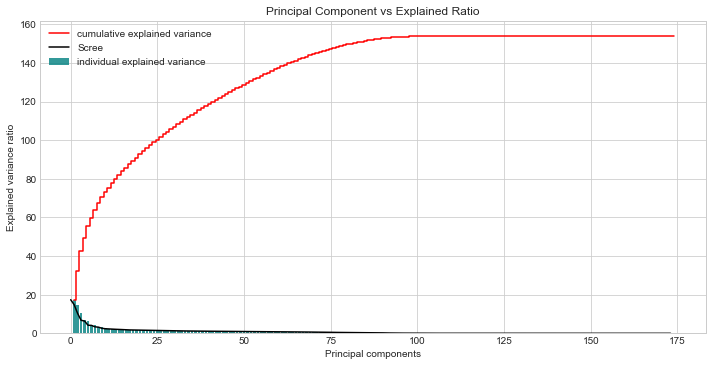

In [17]:


pca = PCA()
x_train_pca1 = pca.fit_transform(x_train_std)

x_test_pca1 = pca.transform(x_test_std)

plot_variance_scree_plot(pca.explained_variance_ ,np.cumsum(pca.explained_variance_),pca.n_components_ +1 )


We see that close to first 15 is where the elbow point remains. Lets transform to PCA again in with n_components as 15

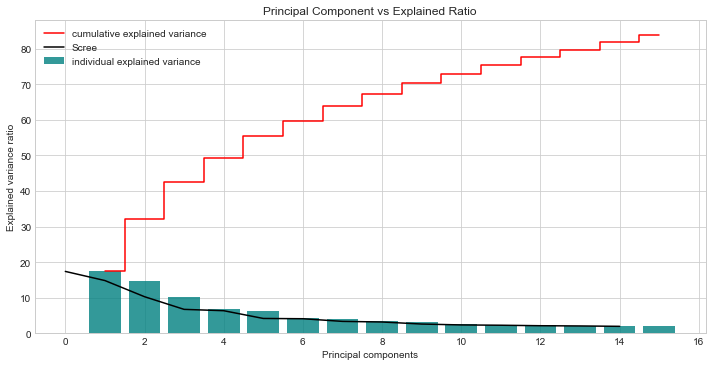

In [18]:
pca = PCA(n_components =15)
pca.fit(x_train_std)
plot_variance_scree_plot(pca.explained_variance_ ,np.cumsum(pca.explained_variance_),pca.n_components_ +1 )


In [19]:
pca = PCA(n_components  = 6)
x_train_std_pca = pca.fit_transform(x_train_std)
x_test_std_pca = pca.transform(x_test_std)

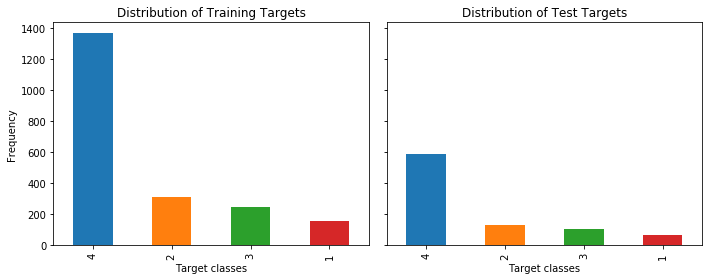

In [20]:


f, (ax1, ax2) = plot.subplots(1, 2, sharey=True, figsize=(10,4))
_y_train.value_counts().plot(kind='bar', label='Distribution of Training targets',ax=ax1)

ax1.set_xlabel('Target classes')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Training Targets')

_y_test.value_counts().plot(kind='bar', label='Distribution of Training targets', ax=ax2)

ax2.set_xlabel('Target classes')
ax2.set_ylabel('Frequency')
ax2.set_title('Distribution of Test Targets')
plot.tight_layout()
plot.show()

In [21]:
cv = StratifiedKFold(n_splits = 5, shuffle= True, random_state =123)
score= 'f1_weighted'
scaler = StandardScaler()

Grid Search Best parameters  {'perceptron__eta0': 0.1, 'perceptron__max_iter': 10}
Grid Search Best score  0.5755543045617121
Code block 'training' took(HH:MM:SS): 0:00:00.352095
Code block 'testing' took(HH:MM:SS): 0:00:00.000379
F1 score 0.5499958638971028
Classification report  
               precision    recall  f1-score   support

           1       0.14      0.13      0.14        67
           2       0.23      0.31      0.26       133
           3       0.14      0.15      0.15       106
           4       0.77      0.70      0.74       586

   micro avg       0.54      0.54      0.54       892
   macro avg       0.32      0.32      0.32       892
weighted avg       0.57      0.54      0.55       892



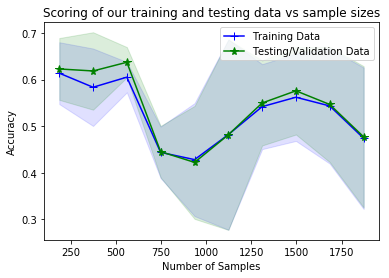

Confusion matrix, without normalization
[[  9  12  22  24]
 [ 29  41  16  47]
 [  7  32  16  51]
 [ 19  95  60 412]]


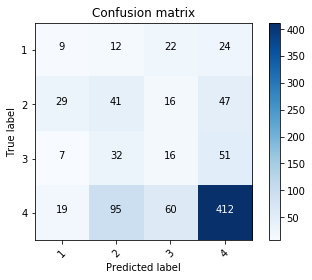

Code block 'learning_curve' took(HH:MM:SS): 0:00:05.739513
Code block 'predict_proba' took(HH:MM:SS): 0:00:00.000028
Grid Search Best parameters  {'logisticregression__C': 100}
Grid Search Best score  0.58697179863098
Code block 'training' took(HH:MM:SS): 0:00:00.366055
Code block 'testing' took(HH:MM:SS): 0:00:00.000737
F1 score 0.5950484505200713
Classification report  
               precision    recall  f1-score   support

           1       1.00      0.03      0.06        67
           2       0.39      0.32      0.35       133
           3       1.00      0.01      0.02       106
           4       0.72      0.95      0.82       586

   micro avg       0.68      0.68      0.68       892
   macro avg       0.78      0.33      0.31       892
weighted avg       0.72      0.68      0.60       892



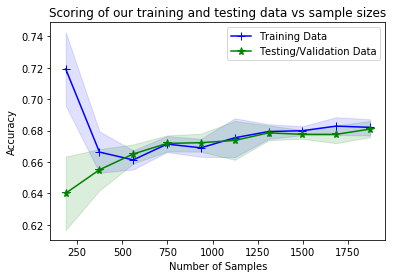

Confusion matrix, without normalization
[[  2  21   0  44]
 [  0  42   0  91]
 [  0  18   1  87]
 [  0  28   0 558]]


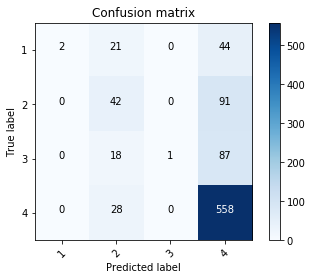

Code block 'learning_curve' took(HH:MM:SS): 0:00:25.039410
inside decision function


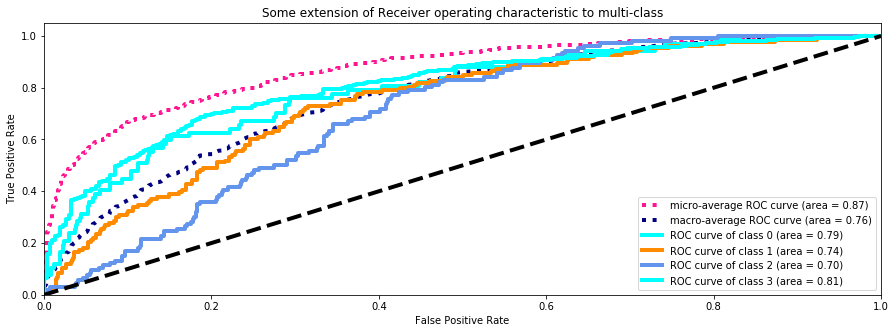

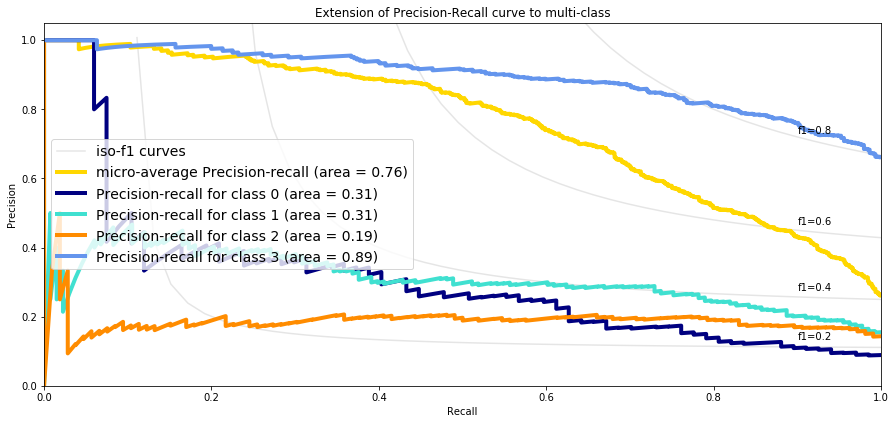

Code block 'predict_proba' took(HH:MM:SS): 0:00:01.053228
Grid Search Best parameters  {'decisiontreeclassifier__criterion': 'gini', 'decisiontreeclassifier__max_depth': 6}
Grid Search Best score  0.5931355146641081
Code block 'training' took(HH:MM:SS): 0:00:00.955825
Code block 'testing' took(HH:MM:SS): 0:00:00.000989
F1 score 0.5969062275048791
Classification report  
               precision    recall  f1-score   support

           1       0.26      0.15      0.19        67
           2       0.34      0.23      0.28       133
           3       0.11      0.03      0.05       106
           4       0.73      0.92      0.82       586

   micro avg       0.65      0.65      0.65       892
   macro avg       0.36      0.33      0.33       892
weighted avg       0.57      0.65      0.60       892



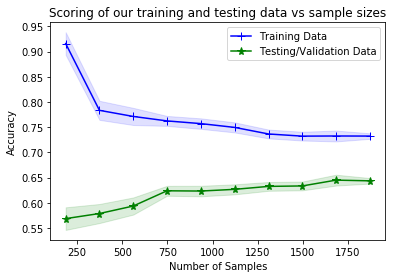

Confusion matrix, without normalization
[[ 10  16   1  40]
 [ 12  31  10  80]
 [  6  21   3  76]
 [ 11  23  13 539]]


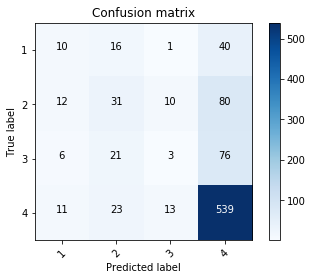

Code block 'learning_curve' took(HH:MM:SS): 0:00:04.659937
inside decision function


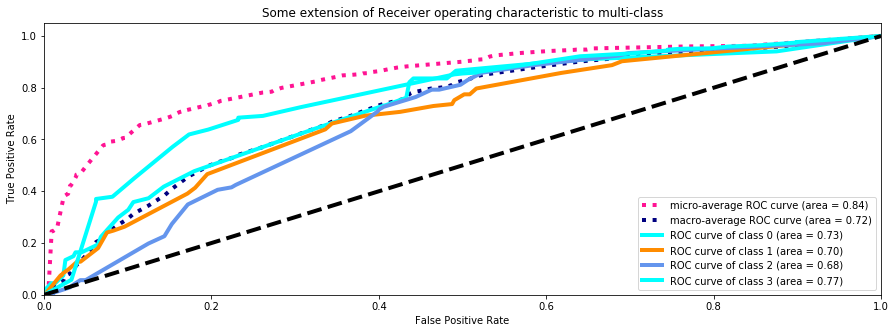

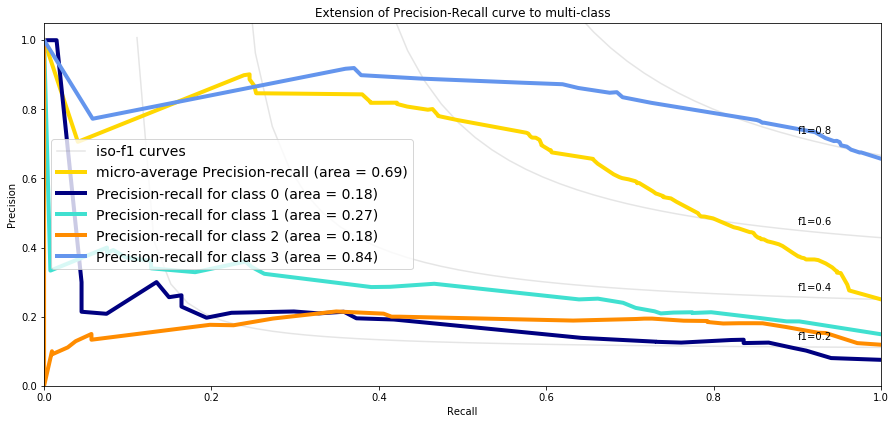

Code block 'predict_proba' took(HH:MM:SS): 0:00:00.893007
Grid Search Best parameters  {'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__n_estimators': 12}
Grid Search Best score  0.6024849486790406
Code block 'training' took(HH:MM:SS): 0:00:01.163087
Code block 'testing' took(HH:MM:SS): 0:00:00.008653
F1 score 0.5999466828332205
Classification report  
               precision    recall  f1-score   support

           1       0.21      0.09      0.12        67
           2       0.30      0.32      0.31       133
           3       0.15      0.08      0.10       106
           4       0.76      0.87      0.81       586

   micro avg       0.63      0.63      0.63       892
   macro avg       0.35      0.34      0.34       892
weighted avg       0.58      0.63      0.60       892



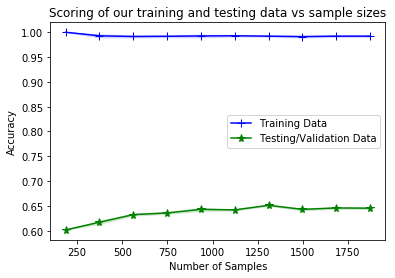

Confusion matrix, without normalization
[[  6  26   8  27]
 [  7  42  15  69]
 [  7  27   8  64]
 [  9  46  22 509]]


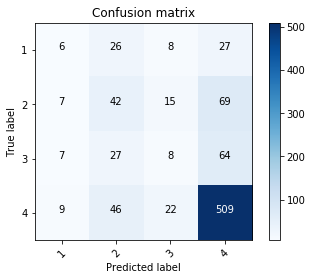

Code block 'learning_curve' took(HH:MM:SS): 0:00:08.526164
inside decision function


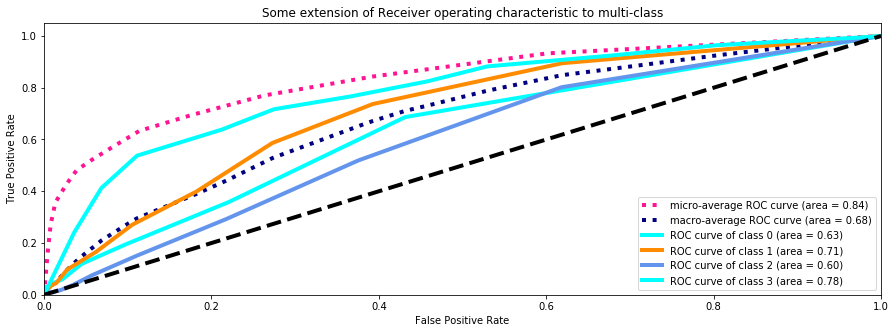

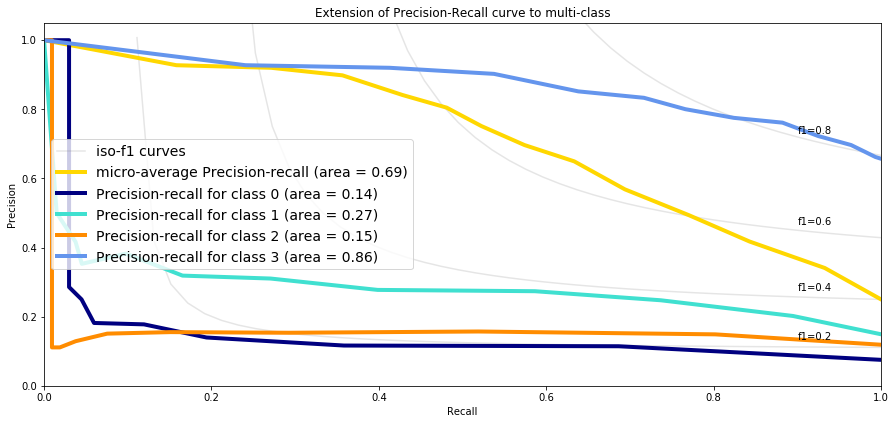

Code block 'predict_proba' took(HH:MM:SS): 0:00:00.864575
Grid Search Best parameters  {'kneighborsclassifier__n_neighbors': 10}
Grid Search Best score  0.5942400704270266
Code block 'training' took(HH:MM:SS): 0:00:00.729108
Code block 'testing' took(HH:MM:SS): 0:00:00.024572
F1 score 0.5979670016366718
Classification report  
               precision    recall  f1-score   support

           1       0.24      0.12      0.16        67
           2       0.27      0.21      0.24       133
           3       0.28      0.12      0.17       106
           4       0.74      0.89      0.81       586

   micro avg       0.64      0.64      0.64       892
   macro avg       0.38      0.34      0.34       892
weighted avg       0.58      0.64      0.60       892



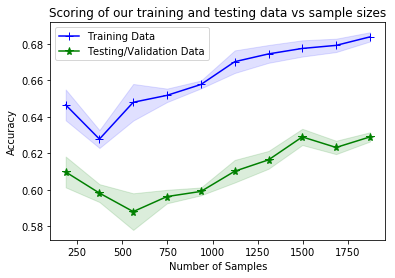

Confusion matrix, without normalization
[[  8  19   3  37]
 [ 12  28  13  80]
 [  4  19  13  70]
 [  9  36  18 523]]


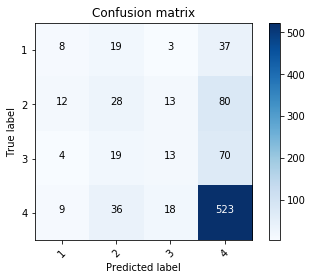

Code block 'learning_curve' took(HH:MM:SS): 0:00:25.048126
inside decision function


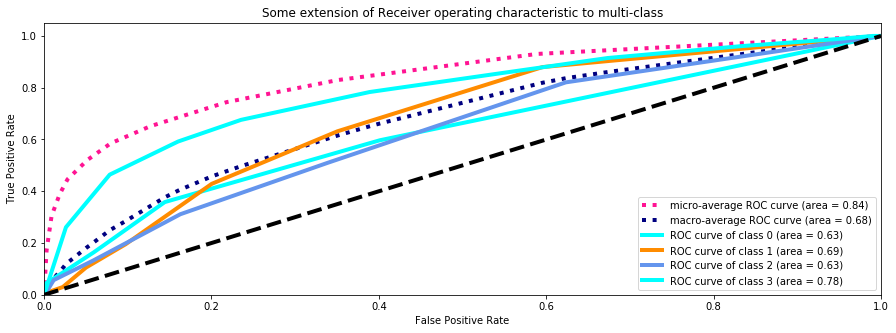

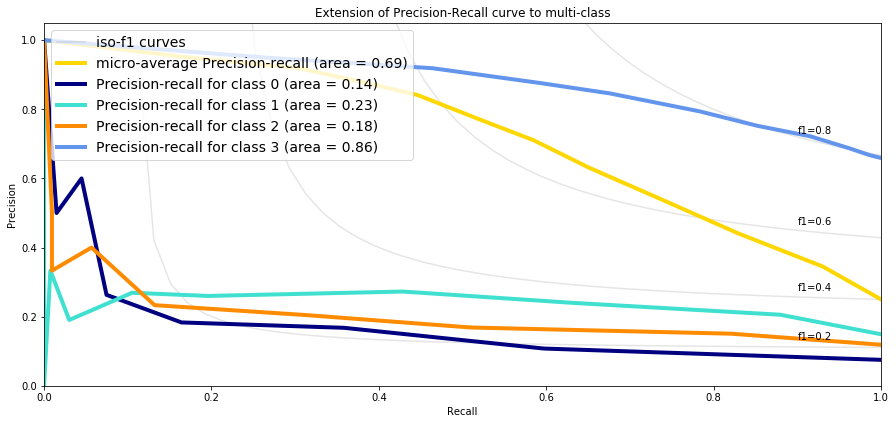

Code block 'predict_proba' took(HH:MM:SS): 0:00:00.926846
Grid Search Best parameters  {'ridge__alpha': 1, 'ridge__max_iter': 100}
Grid Search Best score  0.565146955549749
Code block 'training' took(HH:MM:SS): 0:00:00.416756
Code block 'testing' took(HH:MM:SS): 0:00:00.000350
F1 score 0.5773445446016802
Classification report  
               precision    recall  f1-score   support

           1       0.00      0.00      0.00        67
           2       0.38      0.23      0.28       133
           3       0.00      0.00      0.00       106
           4       0.70      0.97      0.81       586

   micro avg       0.67      0.67      0.67       892
   macro avg       0.27      0.30      0.27       892
weighted avg       0.52      0.67      0.58       892



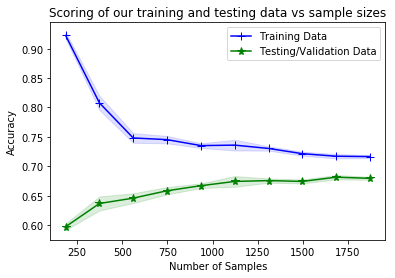

Confusion matrix, without normalization
[[  0  19   0  48]
 [  0  30   0 103]
 [  0  13   0  93]
 [  0  16   0 570]]


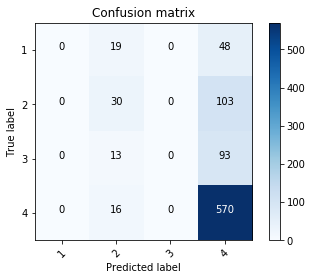

Code block 'learning_curve' took(HH:MM:SS): 0:00:03.043218
Code block 'predict_proba' took(HH:MM:SS): 0:00:00.000028
Grid Search Best parameters  {'svc__C': 1.2, 'svc__max_iter': 200}
Grid Search Best score  0.07218358961446558
Code block 'training' took(HH:MM:SS): 0:00:14.753123
Code block 'testing' took(HH:MM:SS): 0:00:00.046986
F1 score 0.0699049411200539
Classification report  
               precision    recall  f1-score   support

           1       0.10      0.28      0.15        67
           2       0.18      0.45      0.26       133
           3       0.11      0.39      0.17       106
           4       0.00      0.00      0.00       586

   micro avg       0.13      0.13      0.13       892
   macro avg       0.10      0.28      0.14       892
weighted avg       0.05      0.13      0.07       892



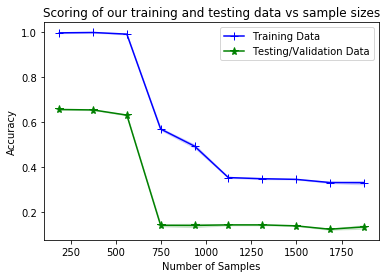

Confusion matrix, without normalization
[[ 19  30  18   0]
 [ 28  60  45   0]
 [ 28  37  41   0]
 [118 209 259   0]]


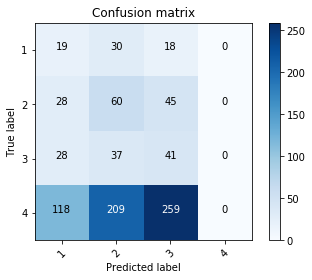

Code block 'learning_curve' took(HH:MM:SS): 0:05:42.938069
inside decision function


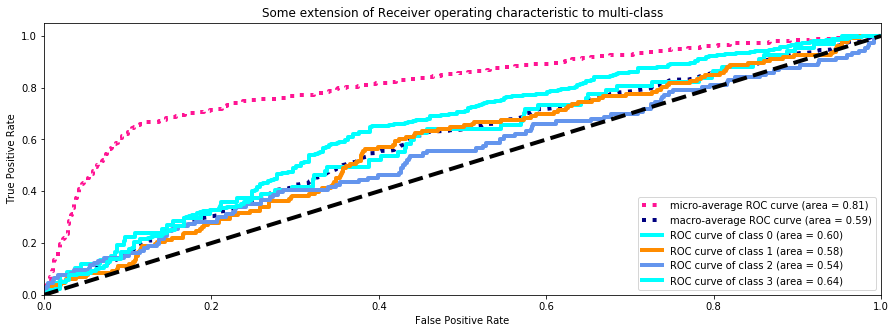

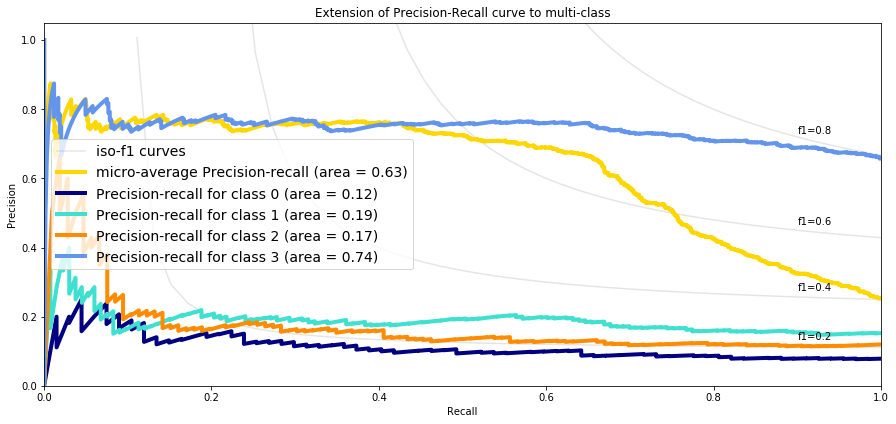

Code block 'predict_proba' took(HH:MM:SS): 0:00:00.725611
Code block 'overalltime' took(HH:MM:SS): 0:07:18.393011
438393.01086463075


In [22]:
response = execute(x_train_std_pca,
        _y_train,
        x_test_std_pca,
        _y_test,
        classifiers,
        classifier_names,
        classifier_param_grid,
        cv=cv,
        score=score,
        scaler=scaler)

In [23]:
results = panda.DataFrame(response).transpose()

# we are sorting our results using f1_score_micro, since it gives the best indicator for sorting multi class imbalanced set
results[['f1_score',
         'f1_score_macro',
         'f1_score_micro',
         'learning_curve_time',
         'roc_auc_macro',
         'roc_auc_micro',
         'testing_time',
         'training_time']]\
.sort_values(by=['f1_score_micro',],ascending=False)

,f1_score,f1_score_macro,f1_score_micro,learning_curve_time,roc_auc_macro,roc_auc_micro,testing_time,training_time
logisticregression,0.595048,0.310188,0.676009,25039.4,0.762622,0.872959,0.737279,366.055
ridge,0.577345,0.274661,0.672646,3043.22,0,0,0.350435,416.756
decisiontreeclassifier,0.596906,0.331657,0.653587,4659.94,0.720057,0.842216,0.988728,955.825
kneighborsclassifier,0.597967,0.343833,0.641256,25048.1,0.681998,0.839463,24.572,729.108
randomforestclassifier,0.599947,0.335838,0.633408,8526.16,0.682465,0.835634,8.65279,1163.09
perceptron,0.549996,0.320139,0.535874,5739.51,0,0,0.379449,352.095
svc,0.0699049,0.144214,0.134529,342938,0.589905,0.814688,46.9856,14753.1


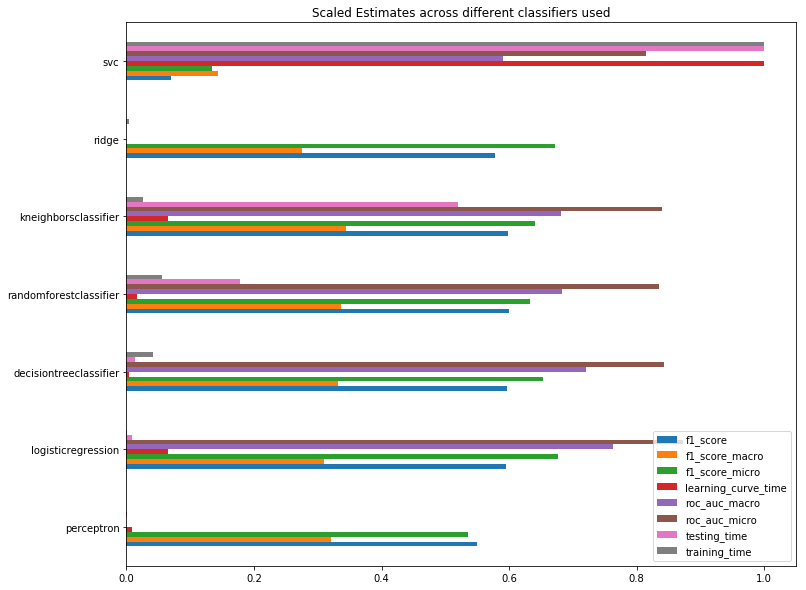

In [24]:
results['learning_curve_time'] = results['learning_curve_time'].astype('float64')
results['testing_time'] = results['testing_time'].astype('float64')
results['training_time'] = results['training_time'].astype('float64')
results['f1_score'] = results['f1_score'].astype('float64')
results['f1_score_micro'] = results['f1_score_micro'].astype('float64')
results['f1_score_macro'] = results['f1_score_macro'].astype('float64')
results['roc_auc_micro'] = results['roc_auc_micro'].astype('float64')
results['roc_auc_macro'] = results['roc_auc_macro'].astype('float64')

#scaling time parameters between 0 and 1
results['learning_curve_time'] = (results['learning_curve_time']- results['learning_curve_time'].min())/(results['learning_curve_time'].max()- results['learning_curve_time'].min())
results['testing_time'] = (results['testing_time']- results['testing_time'].min())/(results['testing_time'].max()- results['testing_time'].min())
results['training_time'] = (results['training_time']- results['training_time'].min())/(results['training_time'].max()- results['training_time'].min())

results.plot(kind='barh',figsize=(12, 10))
plot.title("Scaled Estimates across different classifiers used")
plot.show()

#### Conclusion on dimensionality reduction : very less amount of variance has been defined and results in worse f1 scores

<br><br><br>

##### Lets try LDA and t-SNE techniques

In [25]:
_x_train,_x_test,_y_train,_y_test = train_test_split(x,y, test_size = 0.3, stratify= y, random_state =12)


scaler = StandardScaler()
x_train_std = scaler.fit_transform(_x_train)
x_test_std = scaler.fit_transform(_x_test)

In [26]:
lda = LinearDiscriminantAnalysis()
lda.fit(x_train_std, _y_train)
x_train_lda = lda.transform(x_train_std)
x_test_lda = lda.transform(x_test_std)


In [27]:
cv = StratifiedKFold(n_splits = 5, shuffle= True, random_state =123)
score= 'f1_weighted'
scaler = StandardScaler()

Grid Search Best parameters  {'perceptron__eta0': 0.1, 'perceptron__max_iter': 5}
Grid Search Best score  0.6274278907450741
Code block 'training' took(HH:MM:SS): 0:00:00.223140
Code block 'testing' took(HH:MM:SS): 0:00:00.000537
F1 score 0.5852015402031782
Classification report  
               precision    recall  f1-score   support

           1       0.33      0.01      0.03        67
           2       0.24      0.39      0.30       133
           3       0.22      0.36      0.27       106
           4       0.83      0.72      0.77       586

   micro avg       0.57      0.57      0.57       892
   macro avg       0.41      0.37      0.34       892
weighted avg       0.64      0.57      0.59       892



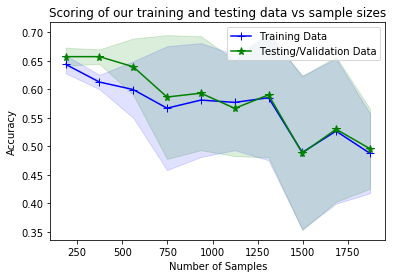

Confusion matrix, without normalization
[[  1  24  26  16]
 [  1  52  48  32]
 [  1  32  38  35]
 [  0 106  61 419]]


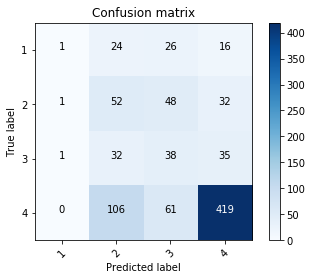

Code block 'learning_curve' took(HH:MM:SS): 0:00:02.947764
Code block 'predict_proba' took(HH:MM:SS): 0:00:00.000020
Grid Search Best parameters  {'logisticregression__C': 100}
Grid Search Best score  0.6900304234033875
Code block 'training' took(HH:MM:SS): 0:00:00.141177
Code block 'testing' took(HH:MM:SS): 0:00:00.000605
F1 score 0.6067906989979795
Classification report  
               precision    recall  f1-score   support

           1       0.29      0.13      0.18        67
           2       0.34      0.27      0.30       133
           3       0.22      0.09      0.13       106
           4       0.74      0.90      0.81       586

   micro avg       0.65      0.65      0.65       892
   macro avg       0.40      0.35      0.36       892
weighted avg       0.58      0.65      0.61       892



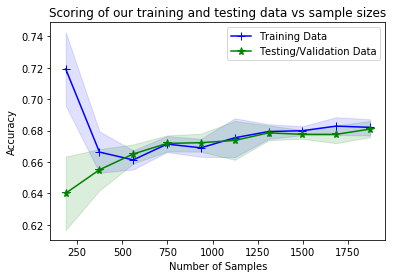

Confusion matrix, without normalization
[[  9  22   2  34]
 [  8  36  11  78]
 [  6  17  10  73]
 [  8  30  23 525]]


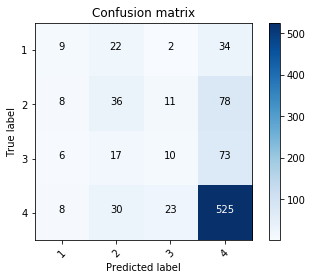

Code block 'learning_curve' took(HH:MM:SS): 0:00:22.964363
inside decision function


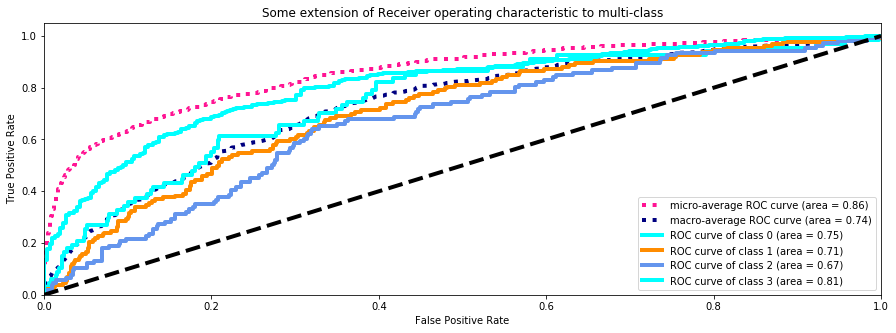

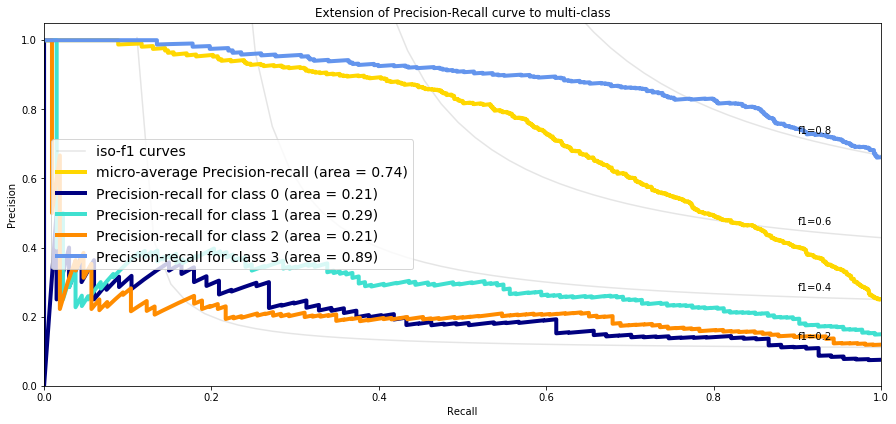

Code block 'predict_proba' took(HH:MM:SS): 0:00:00.704755
Grid Search Best parameters  {'decisiontreeclassifier__criterion': 'gini', 'decisiontreeclassifier__max_depth': 10}
Grid Search Best score  0.6557033552263349
Code block 'training' took(HH:MM:SS): 0:00:00.451909
Code block 'testing' took(HH:MM:SS): 0:00:00.000757
F1 score 0.5865957458665857
Classification report  
               precision    recall  f1-score   support

           1       0.22      0.19      0.20        67
           2       0.26      0.26      0.26       133
           3       0.17      0.14      0.16       106
           4       0.77      0.80      0.78       586

   micro avg       0.60      0.60      0.60       892
   macro avg       0.35      0.35      0.35       892
weighted avg       0.58      0.60      0.59       892



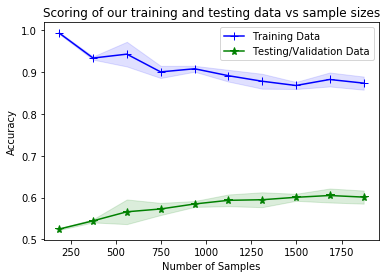

Confusion matrix, without normalization
[[ 13  20   7  27]
 [ 16  35  20  62]
 [ 10  27  15  54]
 [ 21  53  44 468]]


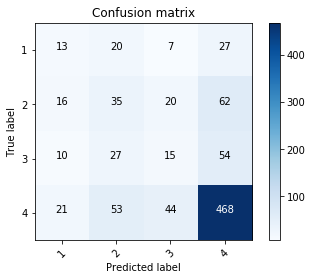

Code block 'learning_curve' took(HH:MM:SS): 0:00:05.010630
inside decision function


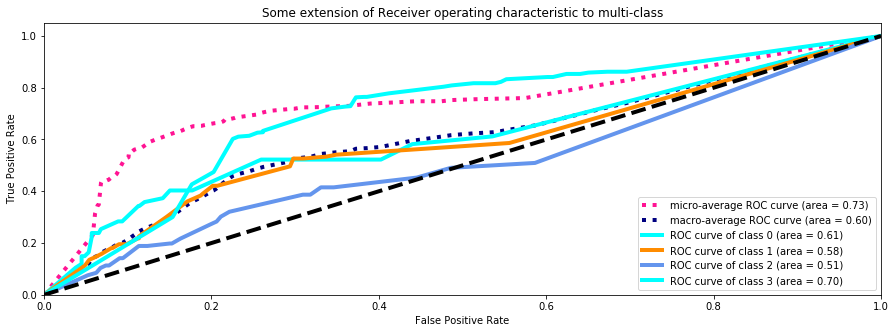

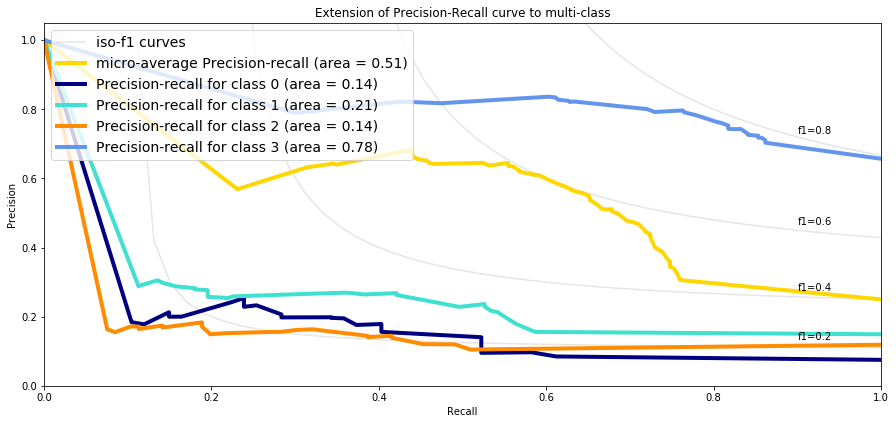

Code block 'predict_proba' took(HH:MM:SS): 0:00:00.671138
Grid Search Best parameters  {'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__n_estimators': 12}
Grid Search Best score  0.6648652263003161
Code block 'training' took(HH:MM:SS): 0:00:00.605129
Code block 'testing' took(HH:MM:SS): 0:00:00.006870
F1 score 0.6225994139928218
Classification report  
               precision    recall  f1-score   support

           1       0.24      0.18      0.21        67
           2       0.31      0.29      0.30       133
           3       0.25      0.16      0.19       106
           4       0.78      0.86      0.82       586

   micro avg       0.64      0.64      0.64       892
   macro avg       0.39      0.37      0.38       892
weighted avg       0.61      0.64      0.62       892



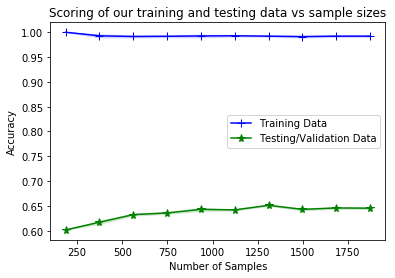

Confusion matrix, without normalization
[[ 12  23   7  25]
 [ 14  39  19  61]
 [  7  27  17  55]
 [ 17  37  26 506]]


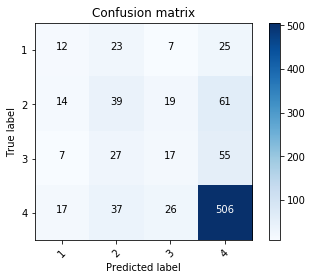

Code block 'learning_curve' took(HH:MM:SS): 0:00:06.427745
inside decision function


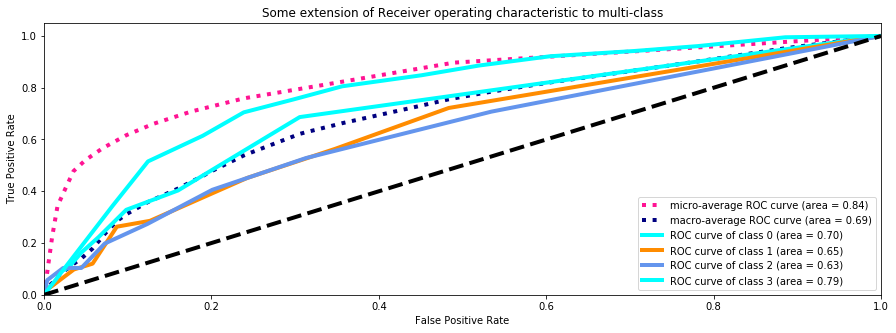

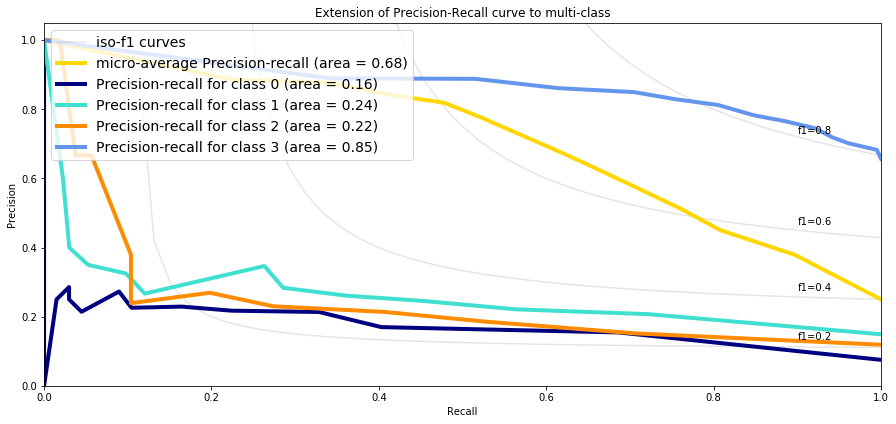

Code block 'predict_proba' took(HH:MM:SS): 0:00:00.626983
Grid Search Best parameters  {'kneighborsclassifier__n_neighbors': 10}
Grid Search Best score  0.6920455654026024
Code block 'training' took(HH:MM:SS): 0:00:00.306431
Code block 'testing' took(HH:MM:SS): 0:00:00.009892
F1 score 0.619412863754701
Classification report  
               precision    recall  f1-score   support

           1       0.34      0.27      0.30        67
           2       0.34      0.29      0.31       133
           3       0.22      0.13      0.16       106
           4       0.76      0.86      0.81       586

   micro avg       0.64      0.64      0.64       892
   macro avg       0.41      0.39      0.40       892
weighted avg       0.60      0.64      0.62       892



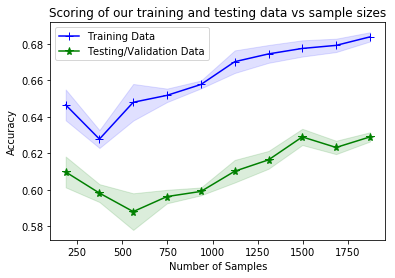

Confusion matrix, without normalization
[[ 18  15   9  25]
 [ 15  39  11  68]
 [  9  19  14  64]
 [ 11  42  30 503]]


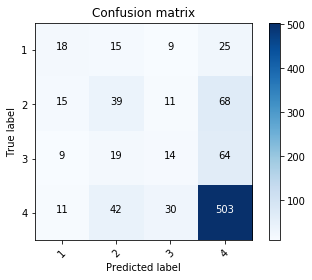

Code block 'learning_curve' took(HH:MM:SS): 0:00:18.058233
inside decision function


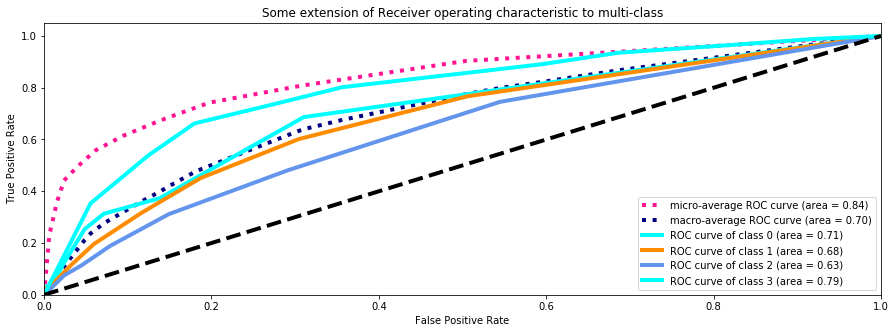

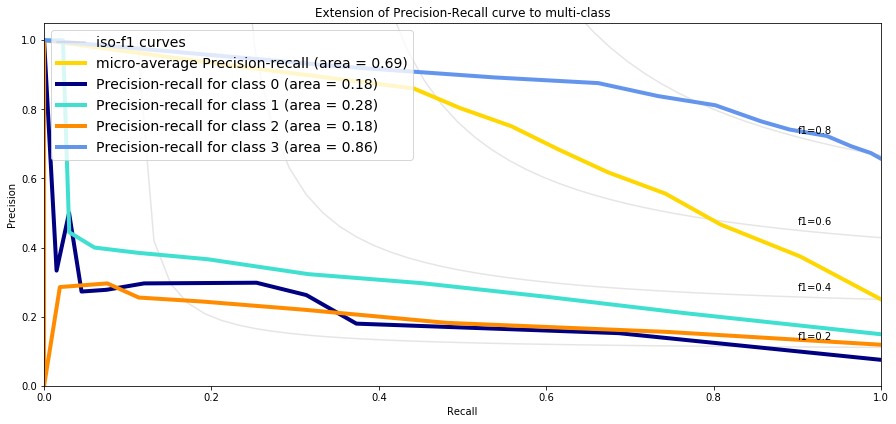

Code block 'predict_proba' took(HH:MM:SS): 0:00:00.700133
Grid Search Best parameters  {'ridge__alpha': 1, 'ridge__max_iter': 100}
Grid Search Best score  0.6566353200383552
Code block 'training' took(HH:MM:SS): 0:00:00.318265
Code block 'testing' took(HH:MM:SS): 0:00:00.000156
F1 score 0.6055660898633115
Classification report  
               precision    recall  f1-score   support

           1       0.29      0.09      0.14        67
           2       0.36      0.27      0.31       133
           3       0.29      0.08      0.12       106
           4       0.73      0.92      0.81       586

   micro avg       0.66      0.66      0.66       892
   macro avg       0.41      0.34      0.34       892
weighted avg       0.59      0.66      0.61       892



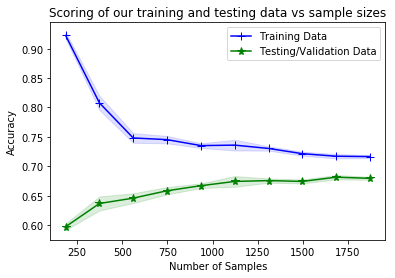

Confusion matrix, without normalization
[[  6  23   0  38]
 [  8  36   7  82]
 [  3  14   8  81]
 [  4  28  13 541]]


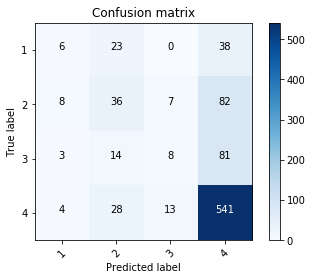

Code block 'learning_curve' took(HH:MM:SS): 0:00:02.305282
Code block 'predict_proba' took(HH:MM:SS): 0:00:00.000016
Grid Search Best parameters  {'svc__C': 1.2, 'svc__max_iter': 200}
Grid Search Best score  0.11562999365231905
Code block 'training' took(HH:MM:SS): 0:00:08.086494
Code block 'testing' took(HH:MM:SS): 0:00:00.019922
F1 score 0.06884755175804892
Classification report  
               precision    recall  f1-score   support

           1       0.09      0.40      0.15        67
           2       0.18      0.27      0.21       133
           3       0.14      0.51      0.22       106
           4       0.00      0.00      0.00       586

   micro avg       0.13      0.13      0.13       892
   macro avg       0.10      0.30      0.14       892
weighted avg       0.05      0.13      0.07       892



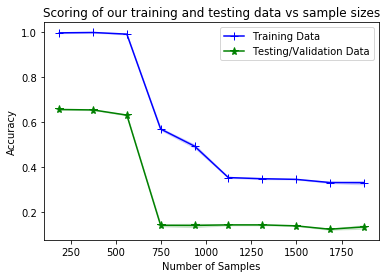

Confusion matrix, without normalization
[[ 27  14  26   0]
 [ 34  36  63   0]
 [ 28  24  54   0]
 [205 128 253   0]]


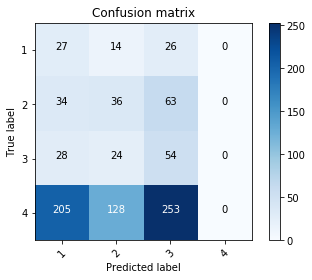

Code block 'learning_curve' took(HH:MM:SS): 0:05:31.590291
inside decision function


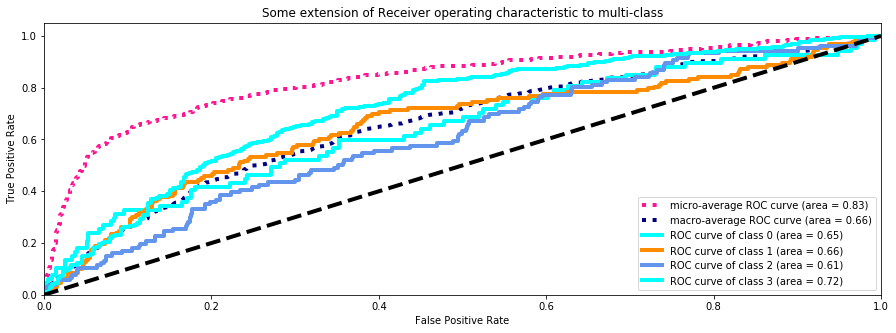

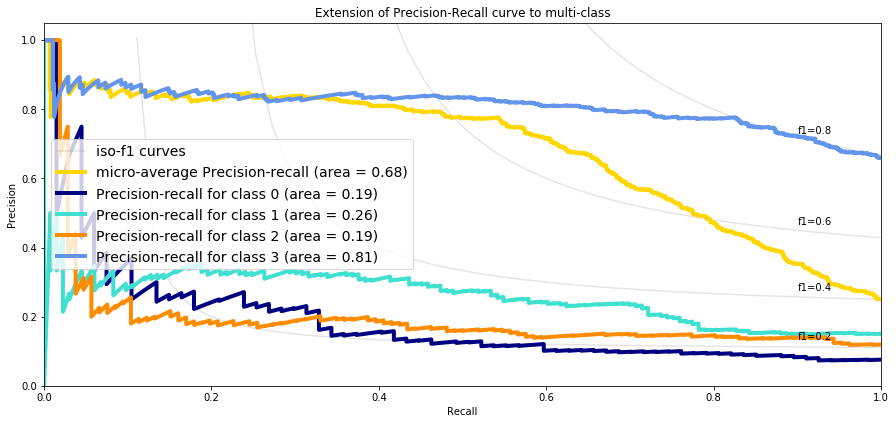

Code block 'predict_proba' took(HH:MM:SS): 0:00:00.900248
Code block 'overalltime' took(HH:MM:SS): 0:06:43.170176
403170.175570339


In [28]:
response = execute(x_train_lda,
        _y_train,
        x_test_lda,
        _y_test,
        classifiers,
        classifier_names,
        classifier_param_grid,
        cv=cv,
        score=score,
        scaler=scaler)

In [29]:
results = panda.DataFrame(response).transpose()

# we are sorting our results using f1_score_micro, since it gives the best indicator for sorting multi class imbalanced set
results[['f1_score',
         'f1_score_macro',
         'f1_score_micro',
         'learning_curve_time',
         'roc_auc_macro',
         'roc_auc_micro',
         'testing_time',
         'training_time']]\
.sort_values(by=['f1_score_micro',],ascending=False)

,f1_score,f1_score_macro,f1_score_micro,learning_curve_time,roc_auc_macro,roc_auc_micro,testing_time,training_time
ridge,0.605566,0.344554,0.662556,2305.28,0,0,0.156444,318.265
logisticregression,0.606791,0.35699,0.650224,22964.4,0.73682,0.85688,0.604728,141.177
randomforestclassifier,0.622599,0.380334,0.643498,6427.75,0.693378,0.835225,6.87047,605.129
kneighborsclassifier,0.619413,0.396651,0.643498,18058.2,0.704902,0.840619,9.89183,306.431
decisiontreeclassifier,0.586596,0.351031,0.595291,5010.63,0.600233,0.734439,0.75719,451.909
perceptron,0.585202,0.342726,0.571749,2947.76,0,0,0.537031,223.14
svc,0.0688476,0.144912,0.131166,331590,0.662289,0.833842,19.9225,8086.49


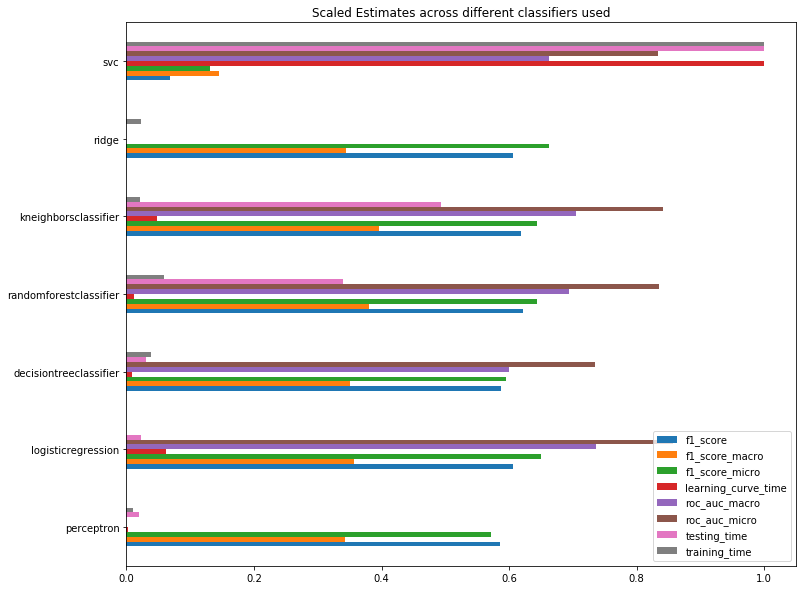

In [30]:
results['learning_curve_time'] = results['learning_curve_time'].astype('float64')
results['testing_time'] = results['testing_time'].astype('float64')
results['training_time'] = results['training_time'].astype('float64')
results['f1_score'] = results['f1_score'].astype('float64')
results['f1_score_micro'] = results['f1_score_micro'].astype('float64')
results['f1_score_macro'] = results['f1_score_macro'].astype('float64')
results['roc_auc_micro'] = results['roc_auc_micro'].astype('float64')
results['roc_auc_macro'] = results['roc_auc_macro'].astype('float64')

#scaling time parameters between 0 and 1
results['learning_curve_time'] = (results['learning_curve_time']- results['learning_curve_time'].min())/(results['learning_curve_time'].max()- results['learning_curve_time'].min())
results['testing_time'] = (results['testing_time']- results['testing_time'].min())/(results['testing_time'].max()- results['testing_time'].min())
results['training_time'] = (results['training_time']- results['training_time'].min())/(results['training_time'].max()- results['training_time'].min())

results.plot(kind='barh',figsize=(12, 10))
plot.title("Scaled Estimates across different classifiers used")
plot.show()

#### Conclusion: We do see better f1 macro score for Kneighbor classifier using LDA reduction

#### t-SNE technique

In [31]:
_x_train,_x_test,_y_train,_y_test = train_test_split(x,y, test_size = 0.3, stratify= y, random_state =12)


scaler = StandardScaler()
x_train_std = scaler.fit_transform(_x_train)
x_test_std = scaler.fit_transform(_x_test)

In [33]:
tsne = TSNE()
# tsne.fit(x_train_std, _y_train)
x_train_tsne = tsne.fit_transform(x_train_std)
x_test_tsne = tsne.fit_transform(x_test_std)


In [34]:
cv = StratifiedKFold(n_splits = 5, shuffle= True, random_state =123)
score= 'f1_weighted'
scaler = StandardScaler()

Grid Search Best parameters  {'perceptron__eta0': 0.1, 'perceptron__max_iter': 30}
Grid Search Best score  0.46974026835538885
Code block 'training' took(HH:MM:SS): 0:00:00.266369
Code block 'testing' took(HH:MM:SS): 0:00:00.000674
F1 score 0.4576939576446385
Classification report  
               precision    recall  f1-score   support

           1       0.00      0.00      0.00        67
           2       0.11      0.19      0.14       133
           3       0.00      0.00      0.00       106
           4       0.62      0.71      0.66       586

   micro avg       0.50      0.50      0.50       892
   macro avg       0.18      0.23      0.20       892
weighted avg       0.43      0.50      0.46       892



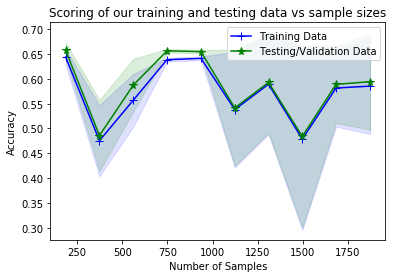

Confusion matrix, without normalization
[[  0   6   0  61]
 [  0  25   0 108]
 [  0  21   0  85]
 [  0 168   0 418]]


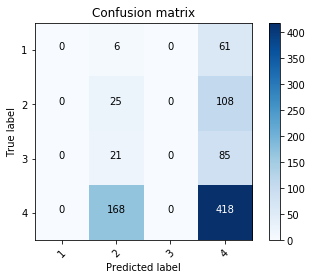

Code block 'learning_curve' took(HH:MM:SS): 0:00:12.166312
Code block 'predict_proba' took(HH:MM:SS): 0:00:00.000027
Grid Search Best parameters  {'logisticregression__C': 100}
Grid Search Best score  0.5214796104890438
Code block 'training' took(HH:MM:SS): 0:00:00.228413
Code block 'testing' took(HH:MM:SS): 0:00:00.000765
F1 score 0.5209378811507491
Classification report  
               precision    recall  f1-score   support

           1       0.00      0.00      0.00        67
           2       0.00      0.00      0.00       133
           3       0.00      0.00      0.00       106
           4       0.66      1.00      0.79       586

   micro avg       0.66      0.66      0.66       892
   macro avg       0.16      0.25      0.20       892
weighted avg       0.43      0.66      0.52       892



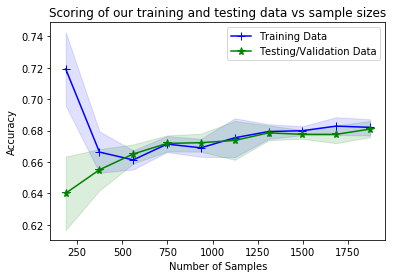

Confusion matrix, without normalization
[[  0   0   0  67]
 [  0   0   0 133]
 [  0   0   0 106]
 [  0   0   0 586]]


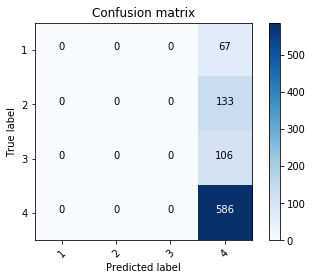

Code block 'learning_curve' took(HH:MM:SS): 0:00:25.048361
inside decision function


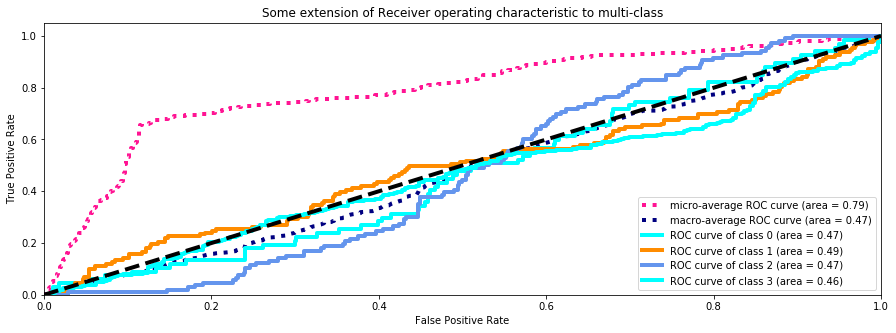

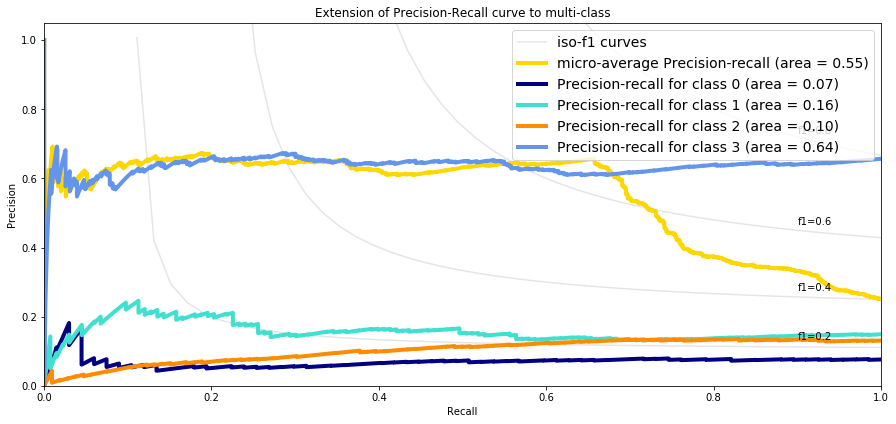

Code block 'predict_proba' took(HH:MM:SS): 0:00:00.908329
Grid Search Best parameters  {'decisiontreeclassifier__criterion': 'entropy', 'decisiontreeclassifier__max_depth': 10}
Grid Search Best score  0.5690663309149658
Code block 'training' took(HH:MM:SS): 0:00:00.464898
Code block 'testing' took(HH:MM:SS): 0:00:00.000691
F1 score 0.47902625098956325
Classification report  
               precision    recall  f1-score   support

           1       0.11      0.18      0.14        67
           2       0.24      0.35      0.29       133
           3       0.06      0.04      0.05       106
           4       0.68      0.61      0.64       586

   micro avg       0.47      0.47      0.47       892
   macro avg       0.27      0.29      0.28       892
weighted avg       0.50      0.47      0.48       892



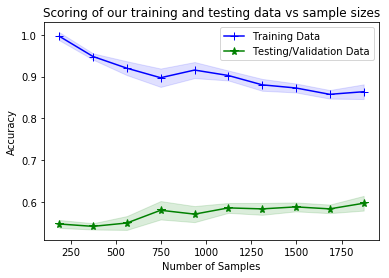

Confusion matrix, without normalization
[[ 12  17   2  36]
 [ 12  47   5  69]
 [ 13  26   4  63]
 [ 72 106  53 355]]


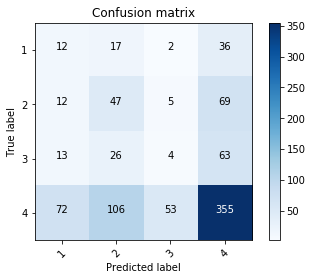

Code block 'learning_curve' took(HH:MM:SS): 0:00:07.674975
inside decision function


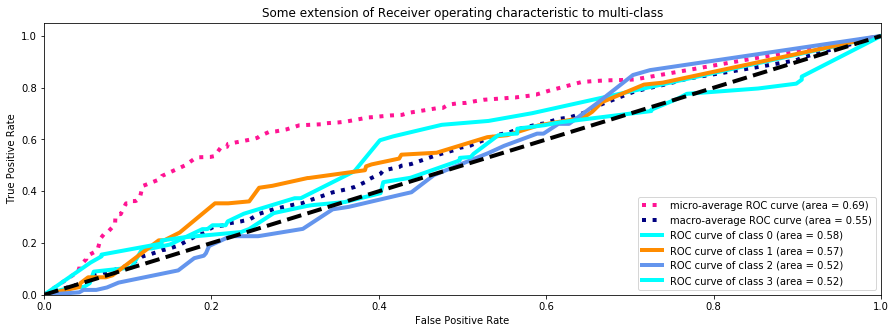

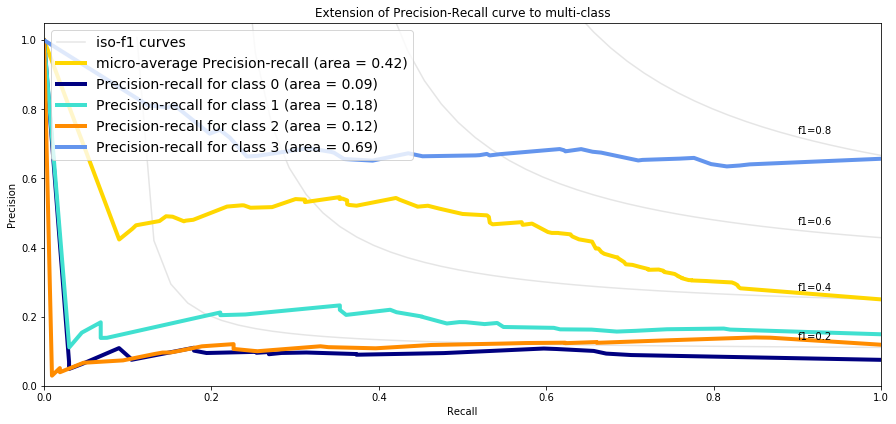

Code block 'predict_proba' took(HH:MM:SS): 0:00:00.870288
Grid Search Best parameters  {'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__n_estimators': 12}
Grid Search Best score  0.5727449124197774
Code block 'training' took(HH:MM:SS): 0:00:00.856265
Code block 'testing' took(HH:MM:SS): 0:00:00.005352
F1 score 0.4677969020764957
Classification report  
               precision    recall  f1-score   support

           1       0.10      0.09      0.10        67
           2       0.18      0.27      0.22       133
           3       0.10      0.09      0.10       106
           4       0.66      0.61      0.63       586

   micro avg       0.46      0.46      0.46       892
   macro avg       0.26      0.27      0.26       892
weighted avg       0.48      0.46      0.47       892



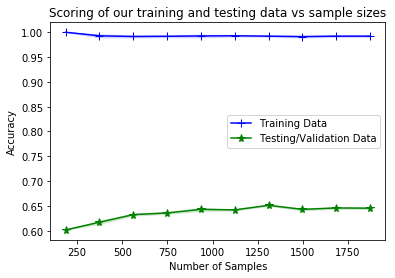

Confusion matrix, without normalization
[[  6  19   5  37]
 [  9  36  11  77]
 [ 10  19  10  67]
 [ 33 123  74 356]]


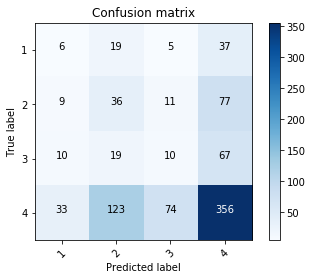

Code block 'learning_curve' took(HH:MM:SS): 0:00:08.518548
inside decision function


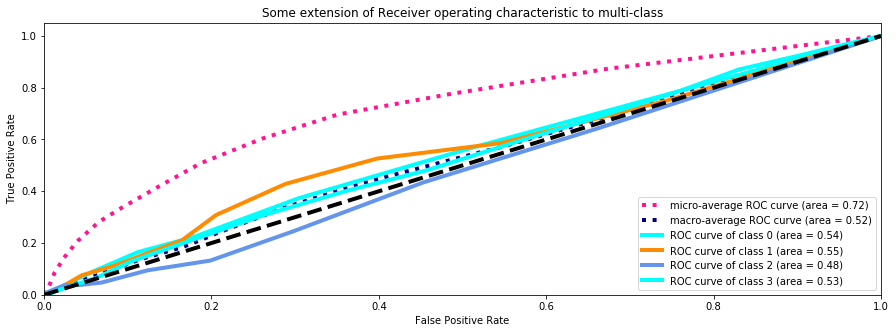

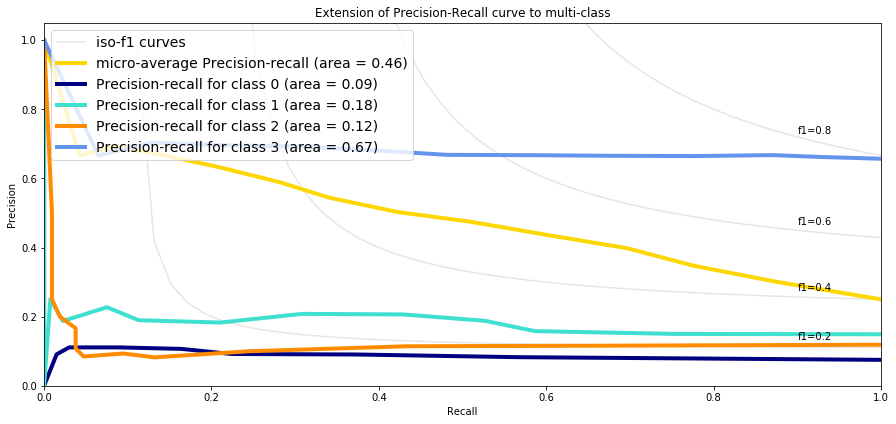

Code block 'predict_proba' took(HH:MM:SS): 0:00:00.860462
Grid Search Best parameters  {'kneighborsclassifier__n_neighbors': 10}
Grid Search Best score  0.583275997004879
Code block 'training' took(HH:MM:SS): 0:00:00.307984
Code block 'testing' took(HH:MM:SS): 0:00:00.007445
F1 score 0.5028021751922301
Classification report  
               precision    recall  f1-score   support

           1       0.07      0.06      0.07        67
           2       0.21      0.25      0.23       133
           3       0.13      0.06      0.08       106
           4       0.67      0.72      0.69       586

   micro avg       0.52      0.52      0.52       892
   macro avg       0.27      0.27      0.27       892
weighted avg       0.49      0.52      0.50       892



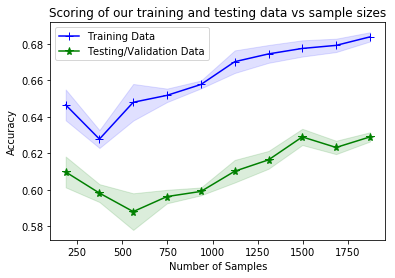

Confusion matrix, without normalization
[[  4  14   3  46]
 [ 11  33   5  84]
 [  9  12   6  79]
 [ 32 100  33 421]]


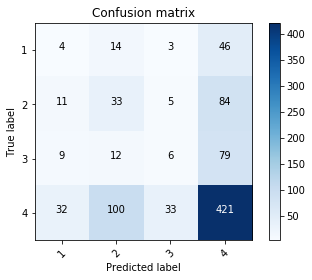

Code block 'learning_curve' took(HH:MM:SS): 0:00:24.667356
inside decision function


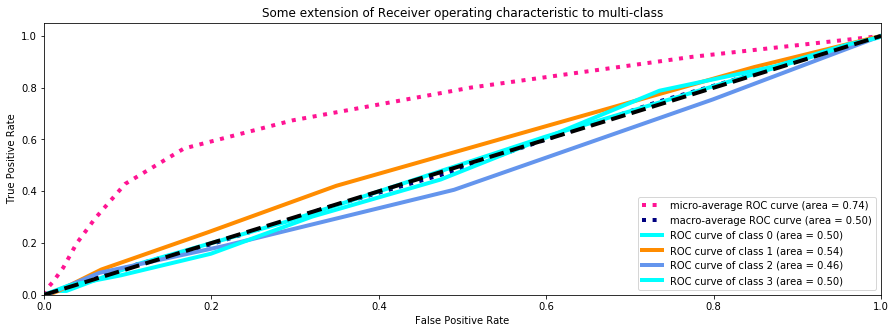

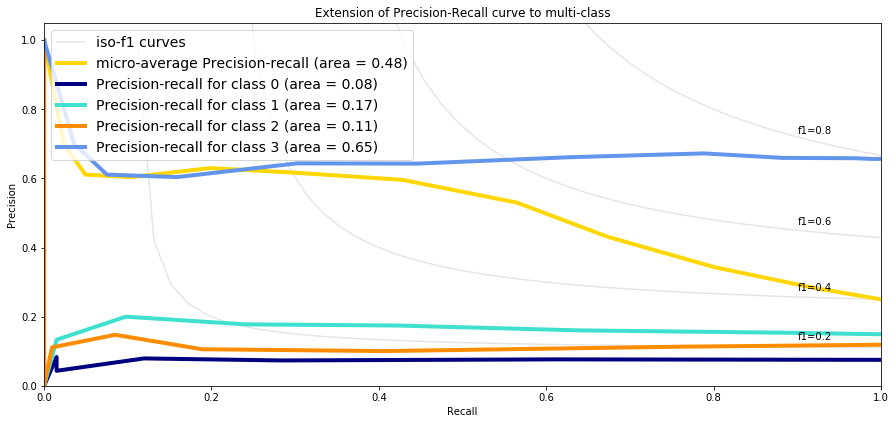

Code block 'predict_proba' took(HH:MM:SS): 0:00:00.853864
Grid Search Best parameters  {'ridge__alpha': 1, 'ridge__max_iter': 100}
Grid Search Best score  0.5214796104890438
Code block 'training' took(HH:MM:SS): 0:00:00.434776
Code block 'testing' took(HH:MM:SS): 0:00:00.000288
F1 score 0.5209378811507491
Classification report  
               precision    recall  f1-score   support

           1       0.00      0.00      0.00        67
           2       0.00      0.00      0.00       133
           3       0.00      0.00      0.00       106
           4       0.66      1.00      0.79       586

   micro avg       0.66      0.66      0.66       892
   macro avg       0.16      0.25      0.20       892
weighted avg       0.43      0.66      0.52       892



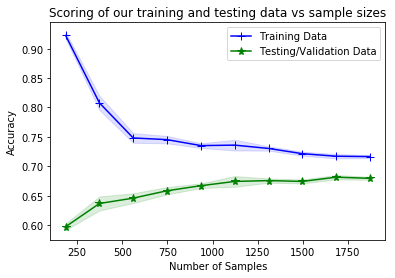

Confusion matrix, without normalization
[[  0   0   0  67]
 [  0   0   0 133]
 [  0   0   0 106]
 [  0   0   0 586]]


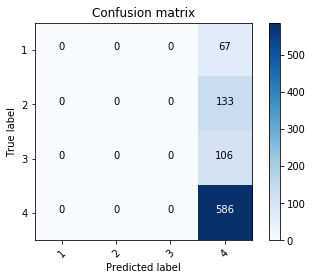

Code block 'learning_curve' took(HH:MM:SS): 0:00:02.970547
Code block 'predict_proba' took(HH:MM:SS): 0:00:00.000030
Grid Search Best parameters  {'svc__C': 1, 'svc__max_iter': 200}
Grid Search Best score  0.07186967726864063
Code block 'training' took(HH:MM:SS): 0:00:32.301518
Code block 'testing' took(HH:MM:SS): 0:00:00.101800
F1 score 0.06954916234700373
Classification report  
               precision    recall  f1-score   support

           1       0.11      0.22      0.15        67
           2       0.19      0.38      0.25       133
           3       0.11      0.50      0.18       106
           4       0.00      0.00      0.00       586

   micro avg       0.13      0.13      0.13       892
   macro avg       0.10      0.27      0.14       892
weighted avg       0.05      0.13      0.07       892



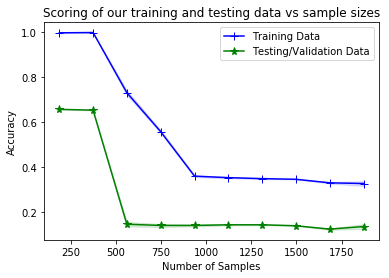

Confusion matrix, without normalization
[[ 15  22  30   0]
 [ 17  50  66   0]
 [ 25  28  53   0]
 [ 76 168 342   0]]


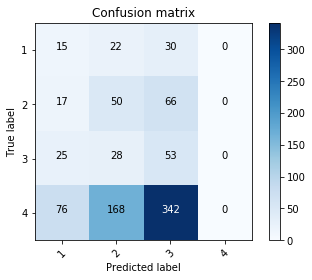

Code block 'learning_curve' took(HH:MM:SS): 0:07:01.994326
inside decision function


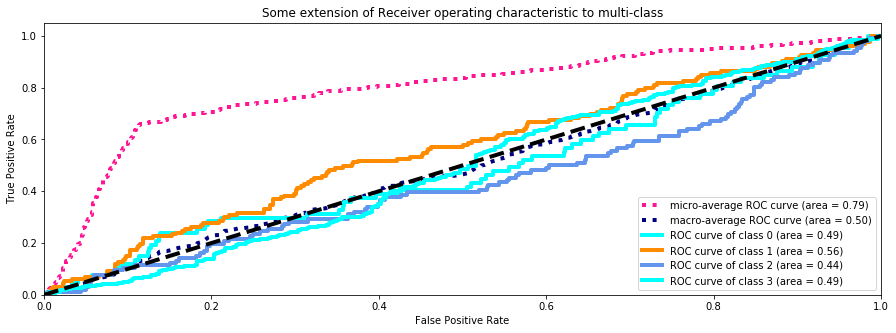

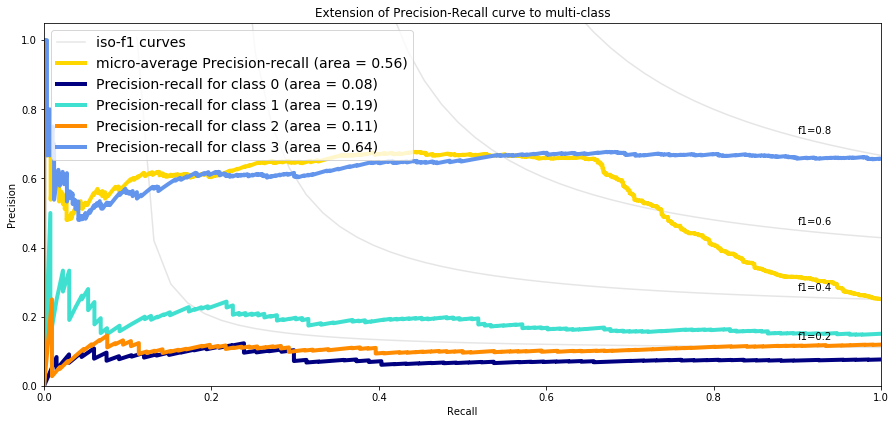

Code block 'predict_proba' took(HH:MM:SS): 0:00:01.033378
Code block 'overalltime' took(HH:MM:SS): 0:09:02.670760
542670.7603876177


In [35]:
response = execute(x_train_tsne,
        _y_train,
        x_test_tsne,
        _y_test,
        classifiers,
        classifier_names,
        classifier_param_grid,
        cv=cv,
        score=score,
        scaler=scaler)

In [36]:
results = panda.DataFrame(response).transpose()

# we are sorting our results using f1_score_micro, since it gives the best indicator for sorting multi class imbalanced set
results[['f1_score',
         'f1_score_macro',
         'f1_score_micro',
         'learning_curve_time',
         'roc_auc_macro',
         'roc_auc_micro',
         'testing_time',
         'training_time']]\
.sort_values(by=['f1_score_micro',],ascending=False)

,f1_score,f1_score_macro,f1_score_micro,learning_curve_time,roc_auc_macro,roc_auc_micro,testing_time,training_time
logisticregression,0.520938,0.198241,0.656951,25048.4,0.472741,0.787751,0.764586,228.413
ridge,0.520938,0.198241,0.656951,2970.55,0,0,0.287858,434.776
kneighborsclassifier,0.502802,0.265483,0.520179,24667.4,0.500799,0.7384,7.44504,307.984
perceptron,0.457694,0.201547,0.496637,12166.3,0,0,0.674133,266.369
decisiontreeclassifier,0.479026,0.277338,0.46861,7674.97,0.545327,0.691844,0.690631,464.898
randomforestclassifier,0.467797,0.261321,0.457399,8518.55,0.523561,0.71861,5.35153,856.265
svc,0.0695492,0.144233,0.132287,421994,0.496843,0.79406,101.8,32301.5


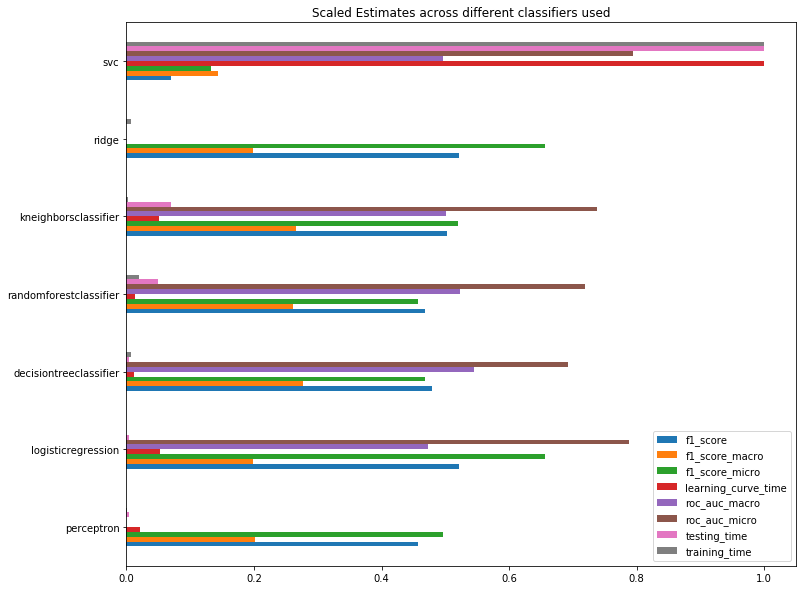

In [37]:
results['learning_curve_time'] = results['learning_curve_time'].astype('float64')
results['testing_time'] = results['testing_time'].astype('float64')
results['training_time'] = results['training_time'].astype('float64')
results['f1_score'] = results['f1_score'].astype('float64')
results['f1_score_micro'] = results['f1_score_micro'].astype('float64')
results['f1_score_macro'] = results['f1_score_macro'].astype('float64')
results['roc_auc_micro'] = results['roc_auc_micro'].astype('float64')
results['roc_auc_macro'] = results['roc_auc_macro'].astype('float64')

#scaling time parameters between 0 and 1
results['learning_curve_time'] = (results['learning_curve_time']- results['learning_curve_time'].min())/(results['learning_curve_time'].max()- results['learning_curve_time'].min())
results['testing_time'] = (results['testing_time']- results['testing_time'].min())/(results['testing_time'].max()- results['testing_time'].min())
results['training_time'] = (results['training_time']- results['training_time'].min())/(results['training_time'].max()- results['training_time'].min())

results.plot(kind='barh',figsize=(12, 10))
plot.title("Scaled Estimates across different classifiers used")
plot.show()

#### Conclusion:  Pretty Similar scores as  LDA techniques